# **DIABETIC RETINOPATHY DETECTION**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import array_to_img
# from sklearn.model_selection import train_test_split
# from PIL import Image
# import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

# from tqdm import tqdm, tqdm_notebook
# from colorama import Fore
# import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
# import time
# from sklearn.decomposition import PCA
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import lightgbm as lgb
# import xgboost as xgb
# !pip install livelossplot
# import livelossplot
# from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

All modules have been imported


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob

%matplotlib inline 

In [34]:
# copy the weights and configurations for the pre-trained models

!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists
mkdir: cannot create directory ‘/root/.keras/models’: File exists
cp: cannot stat '../input/keras-pretrained-models/*notop*': No such file or directory
cp: cannot stat '../input/keras-pretrained-models/imagenet_class_index.json': No such file or directory


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import os
base_image_dir = os.path.join('.', '/content/drive/MyDrive/DL MINI PROJECT/Sample_data_10000')
df = pd.read_csv(os.path.join('/content/drive/MyDrive/DL MINI PROJECT/trainLabels_cropped.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) 
# Most of the files do not exist because this is a sample of the original dataset

df = df[df['exists']]
print(df[df['exists']])
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True)     # Shuffle Dataframe
df['level'] = df['level'].astype(str)
df.head(10)

       Unnamed: 0  Unnamed: 0.1        image  level  \
0               0             0      10_left      0   
1               1             1     10_right      0   
2               2             2      13_left      0   
3               3             3     13_right      0   
4               4             4      15_left      1   
...           ...           ...          ...    ...   
10183       10183         10190   12838_left      0   
10184       10184         10191  12838_right      0   
10185       10185         10192   12839_left      2   
10186       10186         10193  12839_right      2   
10187       10187         10194   12842_left      0   

                                                    path  exists  
0      /content/drive/MyDrive/DL MINI PROJECT/Sample_...    True  
1      /content/drive/MyDrive/DL MINI PROJECT/Sample_...    True  
2      /content/drive/MyDrive/DL MINI PROJECT/Sample_...    True  
3      /content/drive/MyDrive/DL MINI PROJECT/Sample_...    True  
4   

,Unnamed: 0,Unnamed: 0.1,level,path
0,2207,2210,0,/content/drive/MyDrive/DL MINI PROJECT/Sample_...
1,7192,7196,0,/content/drive/MyDrive/DL MINI PROJECT/Sample_...
2,6778,6782,0,/content/drive/MyDrive/DL MINI PROJECT/Sample_...
3,3917,3921,0,/content/drive/MyDrive/DL MINI PROJECT/Sample_...
4,1193,1194,0,/content/drive/MyDrive/DL MINI PROJECT/Sample_...
5,5583,5587,0,/content/drive/MyDrive/DL MINI PROJECT/Sample_...
6,5380,5384,0,/content/drive/MyDrive/DL MINI PROJECT/Sample_...
7,7329,7333,1,/content/drive/MyDrive/DL MINI PROJECT/Sample_...
8,8708,8714,0,/content/drive/MyDrive/DL MINI PROJECT/Sample_...
9,10169,10176,0,/content/drive/MyDrive/DL MINI PROJECT/Sample_...


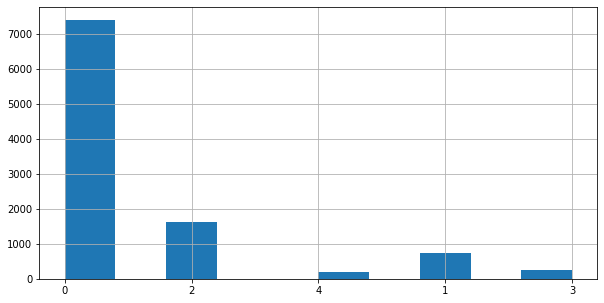

In [7]:
df['level'].hist(figsize = (10, 5))

In [8]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

2038

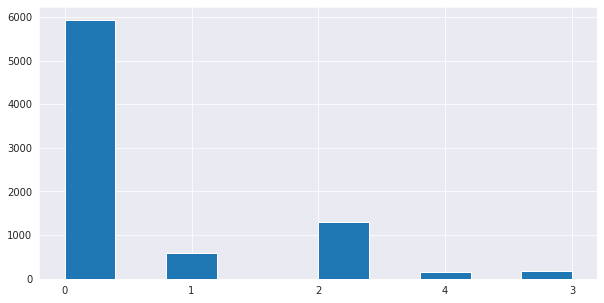

In [36]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) 
# Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set
train_df['level'].hist(figsize = (10, 5))
len(val_df)

New Data Size: 29645 Old Size: 8150


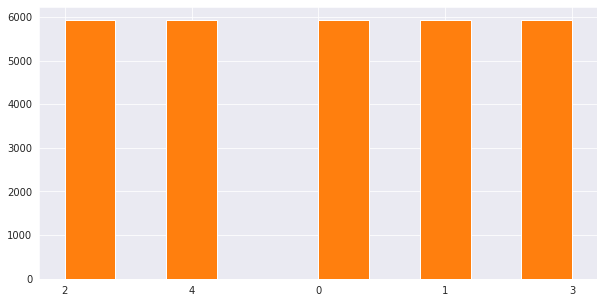

In [37]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) 
# Oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [38]:
df = pd.concat([train_df,val_df]) 
# Beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

31683

In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

In [14]:
x_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=".",
        x_col="path",
        y_col="level",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
x_test = test_datagen.flow_from_dataframe(
        val_df,
        x_col="path",
        y_col="level",
        directory=".",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 29415 validated image filenames belonging to 5 classes.
Found 2038 validated image filenames belonging to 5 classes.


In [15]:
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [16]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
t_x, t_y = next(x_train)

In [18]:
def create_CNN_model(model):
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(264,264,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

In [19]:
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model


in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = 2048
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)

# fan it out to all of the channels

up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model

gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
model = Model(inputs = [in_lay], outputs = [out_layer])


from keras.metrics import top_k_categorical_accuracy

def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['categorical_accuracy', top_2_accuracy])
model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 6, 6, 2048)   21802784    ['input_1[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 6, 6, 2048)  8192        ['inception_v3[0][0]']           
 ormalization)                                                                                    
                             

In [41]:
import tensorflow

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [21]:
filepath = "dr-detector.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_top2_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

earlystop = EarlyStopping(monitor='val_categorical_accuracy',
                          verbose=1, 
                          min_delta=0, 
                          patience=15, 
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              verbose=1,
                              factor=0.2, 
                              patience=6, 
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.001)


callbacks = [checkpoint, earlystop, reduce_lr]

In [23]:
history = model.fit(
        x_train,
        steps_per_epoch=x_train.samples // 64,
        epochs=5,
        validation_data=x_test,
        validation_steps=x_test.samples // 64,
        callbacks=callbacks)
model.save_weights("dr_messidor.h5")

Epoch 1/5
459/459 [==============================] - ETA: 0s - loss: 1.2666 - categorical_accuracy: 0.4466 - top_2_accuracy: 0.6961

459/459 [==============================] - 3488s 8s/step - loss: 1.2666 - categorical_accuracy: 0.4466 - top_2_accuracy: 0.6961 - val_loss: 1.2296 - val_categorical_accuracy: 0.3931 - val_top_2_accuracy: 0.7359 - lr: 0.0010
Epoch 2/5
459/459 [==============================] - ETA: 0s - loss: 1.0695 - categorical_accuracy: 0.5335 - top_2_accuracy: 0.7706

459/459 [==============================] - 1212s 3s/step - loss: 1.0695 - categorical_accuracy: 0.5335 - top_2_accuracy: 0.7706 - val_loss: 1.3650 - val_categorical_accuracy: 0.3810 - val_top_2_accuracy: 0.7409 - lr: 0.0010
Epoch 3/5
459/459 [==============================] - ETA: 0s - loss: 0.9683 - categorical_accuracy: 0.5772 - top_2_accuracy: 0.8036

459/459 [==============================] - 779s 2s/step - loss: 0.9683 - categorical_accuracy: 0.5772 - top_2_accuracy: 0.8036 - val_loss: 1.1978 - val_categorical_accuracy: 0.3992 - val_top_2_accuracy: 0.8115 - lr: 0.0010
Epoch 4/5
459/459 [==============================] - ETA: 0s - loss: 0.9053 - categorical_accuracy: 0.6081 - top_2_accuracy: 0.8268

459/459 [==============================] - 584s 1s/step - loss: 0.9053 - categorical_accuracy: 0.6081 - top_2_accuracy: 0.8268 - val_loss: 1.3009 - val_categorical_accuracy: 0.2994 - val_top_2_accuracy: 0.7863 - lr: 0.0010
Epoch 5/5
459/459 [==============================] - ETA: 0s - loss: 0.8447 - categorical_accuracy: 0.6347 - top_2_accuracy: 0.8457

459/459 [==============================] - 491s 1s/step - loss: 0.8447 - categorical_accuracy: 0.6347 - top_2_accuracy: 0.8457 - val_loss: 1.1952 - val_categorical_accuracy: 0.3800 - val_top_2_accuracy: 0.8417 - lr: 0.0010


In [24]:
train_score = model.evaluate(x_train)
test_score = model.evaluate(x_test)

64/64 [==============================] - 70s 1s/step - loss: 1.2013 - categorical_accuracy: 0.4048 - top_2_accuracy: 0.8234


In [25]:
print("Final training categorical accuracy = {:.2f} , Final validation categorical accuracy = {:.2f}".format(train_score[1]*100, test_score[1]*100))
print("Final training Top 2 accuracy = {:.2f} , Final validation Top 2 accuracy = {:.2f}".format(train_score[2]*100, test_score[2]*100))
print("Final training loss = {:.2f} , Final validation loss = {:.2f}".format(train_score[0], test_score[0]))

Final training categorical accuracy = 71.46 , Final validation categorical accuracy = 40.48
Final training Top 2 accuracy = 89.54 , Final validation Top 2 accuracy = 82.34
Final training loss = 0.67 , Final validation loss = 1.20


In [26]:
history.history

{'loss': [1.2665711641311646,
  1.0695329904556274,
  0.9682794809341431,
  0.9052607417106628,
  0.8447181582450867],
 'categorical_accuracy': [0.4465661942958832,
  0.5334515571594238,
  0.577235221862793,
  0.6081293225288391,
  0.6346677541732788],
 'top_2_accuracy': [0.6961058378219604,
  0.7705789804458618,
  0.8035872578620911,
  0.8267748951911926,
  0.8456563353538513],
 'val_loss': [1.2295953035354614,
  1.3649520874023438,
  1.1978119611740112,
  1.300923466682434,
  1.195181131362915],
 'val_categorical_accuracy': [0.3931451737880707,
  0.38104838132858276,
  0.39919355511665344,
  0.2993951737880707,
  0.38004031777381897],
 'val_top_2_accuracy': [0.7358871102333069,
  0.7409273982048035,
  0.8114919066429138,
  0.7862903475761414,
  0.8417338728904724],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}

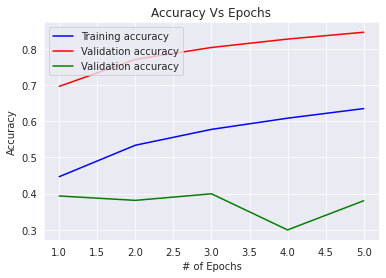

<Figure size 1080x1080 with 0 Axes>

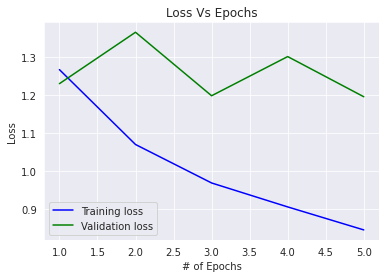

In [33]:
import seaborn as sb

sb.set_style("darkgrid")

Categorical_Acuracy = history.history['categorical_accuracy']
Top_2_Accuracy = history.history['top_2_accuracy']
Val_Categorical_Accuracy = history.history['val_categorical_accuracy']

Loss = history.history['loss']
Val_Loss = history.history['val_loss']

Epochs = range(1, len(Categorical_Acuracy) + 1)

#Train and validation accuracy

plt.plot(Epochs, Categorical_Acuracy, 'b', label='Training accuracy')
plt.plot(Epochs, Top_2_Accuracy, 'r', label='Validation accuracy')
plt.plot(Epochs, Val_Categorical_Accuracy, 'g', label='Validation accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Epochs')
plt.legend()

plt.figure(figsize = (15, 15))
plt.show()

print("\n\n")

#Train and validation loss

plt.plot(Epochs, Loss, 'b', label='Training loss')
plt.plot(Epochs, Val_Loss, 'g', label='Validation loss')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.title('Loss Vs Epochs')
plt.legend()

plt.show()

In [43]:
y_pred = model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)
class_labels = x_test.class_indices
class_labels = {v:k for k,v in class_labels.items()}

920/920 [==============================] - 790s 859ms/step


Confusion Matrix:

[[1037 1355  951 1279 1261]
 [1107 1363  969 1246 1198]
 [1066 1412  920 1251 1234]
 [1092 1464  893 1268 1166]
 [1142 1385  862 1258 1236]]

Classification Report:

              precision    recall  f1-score   support

           0       0.19      0.18      0.18      5883
           1       0.20      0.23      0.21      5883
           2       0.20      0.16      0.18      5883
           3       0.20      0.22      0.21      5883
           4       0.20      0.21      0.21      5883

    accuracy                           0.20     29415
   macro avg       0.20      0.20      0.20     29415
weighted avg       0.20      0.20      0.20     29415



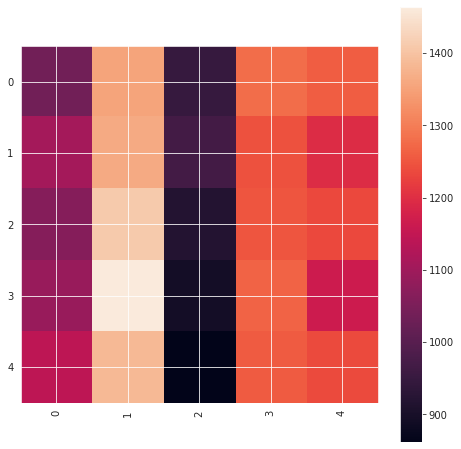

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(x_train.classes, y_pred)
print('Confusion Matrix:\n')
print(cm_train)
print('\nClassification Report:\n')
target_names = list(class_labels.values())
print(classification_report(x_train.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)